# Utilizing daal4py in Data Science Workflows

The notebook below has been made to demonstrate daal4py in a data science context.  It utilizes a Cycling Dataset for pyworkout-toolkit, and attempts to create a linear regression model from the 5 features collected for telemetry to predict the user's Power output in the absence of a power meter.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sys
%matplotlib inline
sys.version

'3.6.5 |Intel Corporation| (default, Aug  3 2018, 14:28:41) \n[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]'

This example will be exploring workout data pulled from Strava, processed into a CSV for Pandas and daal4py usage.  Below, we utilize pandas to read in the CSV file, and look at the head of dataframe with .head()

In [2]:
workout_data_dd= pd.read_csv('data/batch/cycling_dataset.csv', index_col=0)
workout_data_dd.head()

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,185.800003,51,3.46,81,30.313309,-97.732711,45,3.459,2016-10-20T22:01:26.000Z
1,185.800003,68,7.17,82,30.313277,-97.732715,0,3.710,2016-10-20T22:01:27.000Z
2,186.399994,38,11.04,82,30.313243,-97.732717,42,3.874,2016-10-20T22:01:28.000Z
3,186.800003,38,15.18,83,30.313212,-97.732720,5,4.135,2016-10-20T22:01:29.000Z
4,186.600006,38,19.43,83,30.313172,-97.732723,1,4.250,2016-10-20T22:01:30.000Z


The data above has several key features that would be of great use here.  
- Altitude can affect performance, so it might be a useful feature.  
- Cadence is the revolutions per minute of the crank, and may have possible influence.  
- Heart Rate is a measure of the body's workout strain, and would have a high possibly of influence.
- Distance may have a loose correlation as it is highly route dependent, but might be possible.
- Speed has possible correlations as it ties directly into power.

## Explore and visualize some of the data

In general, we are trying to predict on the 'power' in Watts to see if we can generate a model that can predict one's power output without the usage of a cycling power meter.  Below are some basic scatterplots as we explore the data.  Scatterplots are great for looking for patterns and correlation in the data itself.  Below, we can see that cadence and speed are positively correlated.  

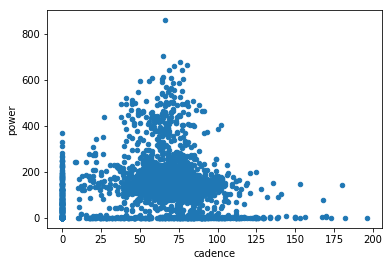

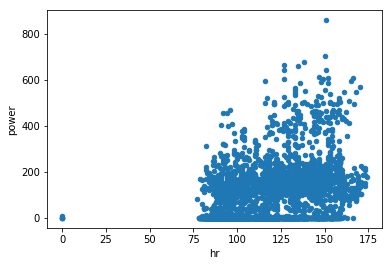

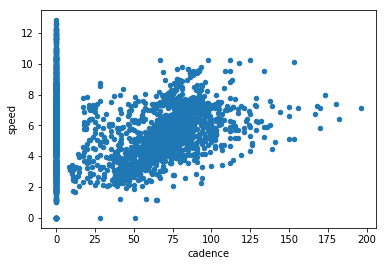

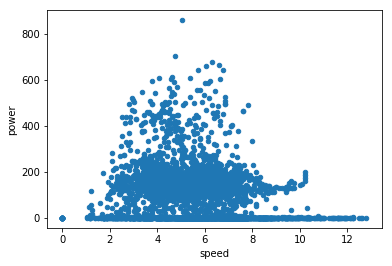

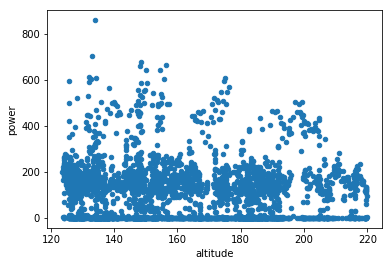

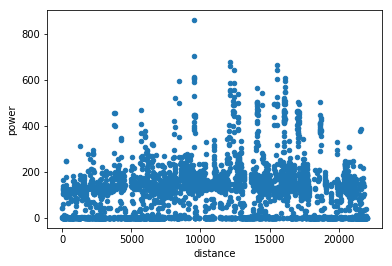

In [3]:
workout_data_dd.plot.scatter('cadence','power')
plt.show()
workout_data_dd.plot.scatter('hr','power')
plt.show()
workout_data_dd.plot.scatter('cadence','speed')
plt.show()
workout_data_dd.plot.scatter('speed','power')
plt.show()
workout_data_dd.plot.scatter('altitude','power')
plt.show()
workout_data_dd.plot.scatter('distance','power')
plt.show()

## Using daal4py for Machine Learning tasks

In the sections below, we will be using daal4py directly.  After importing the model, we will arrange it in a separate independent and dependent dataframes, then use the daal4py's training and prediction classes to generate a workable model.

In [4]:
import daal4py as d4p

It is now the time to split the dataset into train and test sets.  This is demonstrated below.

In [5]:
print(workout_data_dd.shape)
train_set = workout_data_dd[0:3000]
test_set = workout_data_dd[3000:]
print(train_set.shape, test_set.shape)

(3902, 9)
(3000, 9) (902, 9)


In [6]:
# Reduce the dataset, create X.  We drop the target, and other non-essential features.
reduced_dataset = train_set.drop(['time','power','latitude','longitude'], axis=1)
# Get the target, create Y
target = train_set.power.values.reshape((-1,1))
# This is essentially doing np.array(dataset.power.values, ndmin=2).T
# as it needs to force a 2 dimensional array as we only have 1 target

X is 5 features by 3k rows, Y is 3k rows by 1 column

In [7]:
print(reduced_dataset.values.shape, target.shape)

(3000, 5) (3000, 1)


## Training the model

Create the Linear Regression Model, and train the model with the data.  We utilize daal4py's linear_regression_training class to create the model, then call .compute() with the independent and dependent data as the parameters.

In [8]:
d4p_lm = d4p.linear_regression_training(interceptFlag=True)
lm_trained = d4p_lm.compute(reduced_dataset.values, target)

In [9]:
print("Model has this number of features: ", lm_trained.model.NumberOfFeatures)

Model has this number of features:  5


## Prediction (inference) with the trained model

Now that the model is trained, we can test it with the test part of the dataset.  We drop the same features to match that of the trained model, and put it into daal4py's linear_regression_prediction class.

In [10]:
subset = test_set.drop(['time','power','latitude','longitude'], axis=1)

Now we can create the Prediction object and use the reduced dataset for prediction.  The class's arguments use the independent data and the trained model from above as the parameters.

In [11]:
lm_predictor_component = d4p.linear_regression_prediction()
result = lm_predictor_component.compute(subset.values, lm_trained.model)

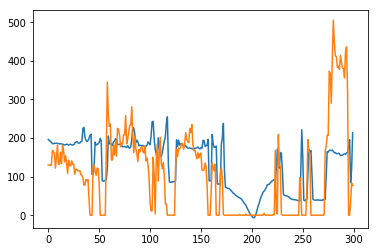

In [12]:
plt.plot(result.prediction[0:300])
plt.plot(test_set.power.values[0:300])
plt.show()

The graph above shows the Orange (predicted) result over the Blue (original data).  This data is notoriously sparse in features leading to a difficult to predict target!

## Model properties
Another aspect of the model is the trained model's properties, which are explored below.

In [13]:
print("Betas:",lm_trained.model.Beta) 
print("Number of betas:", lm_trained.model.NumberOfBetas)
print("Number of Features:", lm_trained.model.NumberOfFeatures)

Betas: [[ 1.51003501e+01 -1.25075548e-01  1.32249115e+00  1.64363922e-03
   8.53155955e-01 -1.09595022e+01]]
Number of betas: 6
Number of Features: 5


## Additional metrics
We can generate metrics on the independent data with daal4py's low_order_moments() class.

In [14]:
metrics_processor = d4p.low_order_moments()
data = metrics_processor.compute(reduced_dataset.values)
data.standardDeviation

array([[1.90063975e+01, 3.75882355e+01, 4.98258371e+03, 2.41394741e+01,
        1.81623064e+00]])

## Migrating the trained model for inference on external systems

Occasionally one may need to migrate the trained model to another system for inference only--this use case allows the training on a much more powerful machine with a larger dataset, and placing the trained model for inference-only on a smaller machine.

In [15]:
import pickle

In [16]:
with open('trained_model2.pickle', 'wb') as model_pi:
    pickle.dump(lm_trained.model, model_pi)
    model_pi.close

The trained model file above can be moved to an inference-only or embedded system.  This is useful if the training is extreamly heavy or computed-limited.  

In [17]:
with open('trained_model2.pickle', 'rb') as model_import:
    lm_import = pickle.load(model_import)

The imported model from file is now usable again.  We can check the betas from the model to ensure that the trained model is present.

In [18]:
lm_import.Beta

array([[ 1.51003501e+01, -1.25075548e-01,  1.32249115e+00,
         1.64363922e-03,  8.53155955e-01, -1.09595022e+01]])